## 1. Import Libraries and Load Data

In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


In [14]:
# Load sector stocks and performance data from EDA
sector_df = pd.read_csv('sector_stocks.csv')
performance_df = pd.read_csv('stock_performance_summary.csv')

print(f"Loaded {len(sector_df)} stocks")
print(f"Performance data for {len(performance_df)} stocks")
performance_df.head()

Loaded 302 stocks
Performance data for 302 stocks


,Symbol,Annual_Return,Volatility,Sharpe_Ratio,Total_Return,Sector,Sector_Code
0,BK,0.473490,0.208432,2.079773,1.444644,Financial,XLF
1,GEV,1.075327,0.528985,1.957193,3.821449,Industrial,XLI
2,HWM,0.705618,0.341155,1.951069,2.606324,Industrial,XLI
3,GLW,0.619943,0.312115,1.858109,2.097819,Technology,XLK
4,GE,0.598812,0.302956,1.844530,1.985152,Industrial,XLI


In [15]:
# Load cached price data
price_data = pd.read_pickle('price_data_all_stocks_cache.pkl')
print(f"Price data shape: {price_data.shape}")
print(f"Date range: {price_data.index[0]} to {price_data.index[-1]}")

Price data shape: (500, 1535)
Date range: 2023-12-08 00:00:00 to 2025-12-05 00:00:00


## 2. Fetch Fundamental Data

Download key financial metrics for all stocks including:
- Revenue & Revenue Growth
- Earnings (EPS) & Earnings Growth
- Profit Margins
- Market Cap
- P/E Ratio, P/B Ratio
- Debt-to-Equity
- ROE, ROA

In [ ]:
# Configuration
USE_SAMPLE = False  # Set to False to fetch for all stocks (takes longer)
SAMPLE_SIZE = 50  # Number of stocks to sample for faster testing

# Stocks to exclude (no data available)
EXCLUDED_STOCKS = ['ANSS', 'CTLT', 'DFS', 'JNPR', 'TPX']

if USE_SAMPLE:
    # Sample stocks proportionally from each sector
    stocks_to_analyze = []
    for sector in sector_df['Sector_Code'].unique():
        sector_stocks = sector_df[sector_df['Sector_Code'] == sector]['Symbol'].head(10).tolist()
        # Filter out excluded stocks
        sector_stocks = [s for s in sector_stocks if s not in EXCLUDED_STOCKS]
        stocks_to_analyze.extend(sector_stocks)
    print(f"Using sample of {len(stocks_to_analyze)} stocks for analysis")
else:
    stocks_to_analyze = sector_df['Symbol'].tolist()
    # Filter out excluded stocks
    stocks_to_analyze = [s for s in stocks_to_analyze if s not in EXCLUDED_STOCKS]
    print(f"Using all {len(stocks_to_analyze)} stocks for analysis")
    print(f"Excluded {len(EXCLUDED_STOCKS)} stocks with missing data: {EXCLUDED_STOCKS}")

Using all 302 stocks for analysis


In [17]:
# Function to fetch fundamental data for a stock
def get_stock_fundamentals(ticker):
    """Fetch key fundamental metrics for a stock"""
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        fundamentals = {
            'Symbol': ticker,
            'Market_Cap': info.get('marketCap', np.nan),
            'PE_Ratio': info.get('trailingPE', np.nan),
            'Forward_PE': info.get('forwardPE', np.nan),
            'PB_Ratio': info.get('priceToBook', np.nan),
            'PS_Ratio': info.get('priceToSalesTrailing12Months', np.nan),
            'Profit_Margin': info.get('profitMargins', np.nan),
            'Operating_Margin': info.get('operatingMargins', np.nan),
            'ROE': info.get('returnOnEquity', np.nan),
            'ROA': info.get('returnOnAssets', np.nan),
            'Debt_to_Equity': info.get('debtToEquity', np.nan),
            'Current_Ratio': info.get('currentRatio', np.nan),
            'Revenue': info.get('totalRevenue', np.nan),
            'Revenue_Growth': info.get('revenueGrowth', np.nan),
            'Earnings_Growth': info.get('earningsGrowth', np.nan),
            'EPS': info.get('trailingEps', np.nan),
            'Beta': info.get('beta', np.nan),
            'Dividend_Yield': info.get('dividendYield', np.nan),
            '52W_High': info.get('fiftyTwoWeekHigh', np.nan),
            '52W_Low': info.get('fiftyTwoWeekLow', np.nan),
        }
        return fundamentals
    except Exception as e:
        print(f"Error fetching {ticker}: {str(e)}")
        return {'Symbol': ticker}

print("Fundamental data fetching function defined")

Fundamental data fetching function defined


In [25]:
# Check for cached fundamentals
import os
fundamentals_cache = 'fundamentals_data_cache.pkl'

if os.path.exists(fundamentals_cache):
    print(f"Loading cached fundamentals from '{fundamentals_cache}'...")
    fundamentals_df = pd.read_pickle(fundamentals_cache)
    print(f"Loaded {len(fundamentals_df)} stocks with fundamentals")
else:
    print("Fetching fundamental data for all stocks...")
    print("This may take several minutes...\n")
    
    fundamentals_list = []
    for i, ticker in enumerate(stocks_to_analyze, 1):
        if i % 10 == 0:
            print(f"Progress: {i}/{len(stocks_to_analyze)} stocks processed")
        fundamentals = get_stock_fundamentals(ticker)
        fundamentals_list.append(fundamentals)
    
    fundamentals_df = pd.DataFrame(fundamentals_list)
    
    # Save cache
    fundamentals_df.to_pickle(fundamentals_cache)
    print(f"\nFundamentals cached to '{fundamentals_cache}'")

print(f"\nFundamentals data shape: {fundamentals_df.shape}")
fundamentals_df.head()

Loading cached fundamentals from 'fundamentals_data_cache.pkl'...
Loaded 302 stocks with fundamentals

Fundamentals data shape: (302, 20)


,Symbol,Market_Cap,PE_Ratio,Forward_PE,PB_Ratio,PS_Ratio,Profit_Margin,Operating_Margin,ROE,ROA,Debt_to_Equity,Current_Ratio,Revenue,Revenue_Growth,Earnings_Growth,EPS,Beta,Dividend_Yield,52W_High,52W_Low
0,AAPL,4137203793920,37.319946,33.547530,55.856540,9.941354,0.26915,0.31647,1.71422,0.22964,152.411,0.893,416161005568,0.079,0.912,7.47,1.107,0.37,288.62,169.21
1,MSFT,3591408713728,34.364150,32.318394,9.892711,12.223492,0.35707,0.48873,0.32241,0.14656,33.154,1.401,293812011008,0.184,0.127,14.06,1.070,0.75,555.45,344.79
2,NVDA,4441136693248,45.263027,44.274273,37.287407,23.731375,0.53007,0.63169,1.07359,0.53528,9.102,4.468,187141996544,0.625,0.667,4.03,2.284,0.02,212.19,86.62
3,AVGO,1842855673856,100.061530,63.247970,6.589554,30.752190,0.31592,0.31765,0.27083,0.08895,166.032,1.497,59925999616,0.164,1.881,3.90,1.204,0.60,403.00,138.10
4,CRM,249104924672,34.835564,23.411500,4.089489,6.178657,0.17913,0.23862,0.12184,0.05950,19.385,0.984,40317001728,0.086,0.386,7.48,1.253,0.64,367.09,221.96


In [26]:
# Merge with sector information
fundamentals_df = fundamentals_df.merge(sector_df[['Symbol', 'Sector', 'Sector_Code']], on='Symbol', how='left')

# Check missing data
print("Missing data summary:")
missing_pct = (fundamentals_df.isnull().sum() / len(fundamentals_df) * 100).sort_values(ascending=False)
print(missing_pct[missing_pct > 0])

print(f"\nTotal stocks with fundamentals: {len(fundamentals_df)}")
fundamentals_df.describe()

Missing data summary:
Dividend_Yield     23.355263
Debt_to_Equity     14.802632
Earnings_Growth     8.881579
ROE                 7.236842
Current_Ratio       5.921053
PE_Ratio            4.934211
Revenue_Growth      0.657895
Beta                0.657895
dtype: float64

Total stocks with fundamentals: 304


,Market_Cap,PE_Ratio,Forward_PE,PB_Ratio,PS_Ratio,Profit_Margin,Operating_Margin,ROE,ROA,Debt_to_Equity,Current_Ratio,Revenue,Revenue_Growth,Earnings_Growth,EPS,Beta,Dividend_Yield,52W_High,52W_Low
count,3.040000e+02,289.000000,304.000000,304.000000,304.000000,304.000000,304.000000,282.000000,304.000000,259.000000,286.000000,3.040000e+02,302.000000,277.000000,304.000000,302.000000,233.000000,304.000000,304.000000
mean,1.385320e+11,33.323858,24.354125,1.261797,4.781576,0.146221,0.222036,0.284901,0.075087,141.458405,1.732608,3.582891e+10,0.098983,0.250025,10.816974,1.069166,1.802318,341.017577,213.602596
std,4.488409e+11,31.346819,29.182232,59.561910,4.500404,0.146224,0.138562,0.499502,0.065879,324.018906,1.374085,7.206891e+10,0.164048,0.874118,29.308045,0.412248,1.258660,699.287121,491.440095
min,2.244960e+09,6.556564,-3.183908,-945.050900,0.112386,-1.396060,-0.255910,-0.628390,-0.154940,0.528000,0.165000,8.392630e+08,-0.454000,-0.903000,-24.020000,0.046000,0.020000,13.130000,6.850000
25%,2.181979e+10,17.693583,13.232344,1.794352,1.896413,0.080210,0.119965,0.102290,0.038120,31.219500,1.001000,6.884500e+09,0.035250,-0.041000,3.125000,0.815000,0.920000,103.611250,62.837500
50%,4.549359e+10,26.258953,19.548547,3.915884,3.579932,0.139365,0.200015,0.173375,0.062185,70.037000,1.358000,1.421000e+10,0.078000,0.105000,6.605000,1.072500,1.570000,211.760000,122.065000
75%,9.840167e+10,35.061478,27.234031,7.965828,5.720031,0.212232,0.315827,0.318748,0.097330,129.266500,2.036000,2.919813e+10,0.123750,0.294000,11.795000,1.309000,2.350000,353.312500,221.660000
max,4.441137e+12,311.643830,429.553200,189.469040,30.752190,0.712200,0.678360,5.638710,0.535280,4217.211000,12.742000,6.913300e+11,2.026000,9.314000,454.550000,2.536000,6.910000,9127.450000,6562.850000


## 3. Feature Engineering

Create technical indicators and derived features

In [31]:
# Extract Close prices for feature engineering
print("Extracting price data...")
print(f"Price data shape: {price_data.shape}")

# The data has MultiIndex columns: (Price Type, Ticker)
# Most stocks have 'Close', but some problematic stocks only have 'Adj Close' (all NaN)
# We'll use 'Close' data and exclude the 5 stocks that only have 'Adj Close'

if isinstance(price_data.columns, pd.MultiIndex):
    # Get all stocks that have 'Close' data (the good stocks)
    if 'Close' in price_data.columns.get_level_values(0):
        adj_close = price_data.xs('Close', level=0, axis=1)
        print(f"✓ Extracted 'Close' price data")
    elif 'Adj Close' in price_data.columns.get_level_values(0):
        adj_close = price_data.xs('Adj Close', level=0, axis=1)
        print(f"✓ Extracted 'Adj Close' price data")
    else:
        raise ValueError("Could not find 'Close' or 'Adj Close' in price data!")
else:
    # If not MultiIndex, use data as-is
    adj_close = price_data
    print("✓ Using price data as-is (not MultiIndex)")

print(f"\nExtracted data shape: {adj_close.shape}")
print(f"Total stocks available: {len(adj_close.columns)}")

# Remove any columns with all NaN values (failed downloads)
nan_counts = adj_close.isna().sum()
all_nan_stocks = nan_counts[nan_counts == len(adj_close)].index.tolist()

if all_nan_stocks:
    print(f"\nRemoving {len(all_nan_stocks)} stocks with all NaN values: {all_nan_stocks}")
    adj_close = adj_close.drop(columns=all_nan_stocks)

print(f"\nFinal data shape: {adj_close.shape}")
print(f"Stocks ready for analysis: {len(adj_close.columns)}")
print(f"Sample stocks: {adj_close.columns[:10].tolist()}")

adj_close.head()

Extracting price data...
Price data shape: (500, 1535)
✓ Extracted 'Close' price data

Extracted data shape: (500, 306)
Total stocks available: 306

Removing 5 stocks with all NaN values: ['ANSS', 'CTLT', 'DFS', 'JNPR', 'TPX']

Final data shape: (500, 301)
Stocks ready for analysis: 301
Sample stocks: ['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADP']


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADP,...,WHR,WM,WRB,WST,WTW,XRAY,XYL,YUM,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-08,125.326698,193.879013,139.150040,140.679993,100.559753,75.406258,327.222900,610.010010,179.478302,220.898636,...,97.958740,167.567154,45.527390,340.320038,236.824570,29.933201,103.976318,119.598450,236.130005,180.392410
2023-12-11,127.070648,191.372681,140.977020,142.910004,102.205109,75.701035,332.152100,625.200012,184.574951,224.771866,...,96.569244,168.421997,46.376282,342.199371,238.903336,29.736027,105.266487,121.801117,239.649994,185.141602
2023-12-12,126.893288,192.888382,142.841324,140.550003,102.647743,76.338135,333.035095,633.659973,185.390381,228.038071,...,96.604431,171.540161,46.778389,345.818970,240.562469,29.970757,105.501076,123.186218,239.380005,187.105820
2023-12-13,131.770401,196.107971,143.829376,144.509995,103.196182,74.531425,333.442627,624.260010,186.652420,230.485321,...,100.913597,173.939575,46.459259,357.662170,241.645782,31.294653,106.713051,125.937149,244.429993,192.910431
2023-12-14,135.928238,196.256531,144.369995,147.259995,104.495155,71.003593,332.559601,584.640015,194.321579,227.353989,...,107.834633,171.617889,45.425266,356.001556,232.208282,32.252369,108.423523,126.110275,272.160004,195.529327


In [32]:
# Function to calculate technical indicators
def calculate_technical_features(prices, ticker):
    """Calculate technical indicators for a stock"""
    if ticker not in prices.columns:
        return {}
    
    price_series = prices[ticker].dropna()
    
    if len(price_series) < 50:
        return {'Symbol': ticker}
    
    features = {'Symbol': ticker}
    
    # Moving averages
    features['MA_20'] = price_series.rolling(20).mean().iloc[-1]
    features['MA_50'] = price_series.rolling(50).mean().iloc[-1]
    features['MA_200'] = price_series.rolling(200).mean().iloc[-1] if len(price_series) >= 200 else np.nan
    
    # Current price relative to moving averages
    current_price = price_series.iloc[-1]
    features['Price_to_MA20'] = current_price / features['MA_20'] if features['MA_20'] > 0 else np.nan
    features['Price_to_MA50'] = current_price / features['MA_50'] if features['MA_50'] > 0 else np.nan
    
    # Momentum indicators
    features['Momentum_20'] = (price_series.iloc[-1] / price_series.iloc[-20] - 1) if len(price_series) >= 20 else np.nan
    features['Momentum_60'] = (price_series.iloc[-1] / price_series.iloc[-60] - 1) if len(price_series) >= 60 else np.nan
    
    # Volatility (standard deviation of returns)
    returns = price_series.pct_change().dropna()
    features['Volatility_20'] = returns.rolling(20).std().iloc[-1] * np.sqrt(252)
    features['Volatility_60'] = returns.rolling(60).std().iloc[-1] * np.sqrt(252)
    
    # RSI (Relative Strength Index)
    delta = price_series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    features['RSI'] = 100 - (100 / (1 + rs.iloc[-1]))
    
    # Price range
    features['52W_Range'] = (current_price - price_series.rolling(252).min().iloc[-1]) / \
                            (price_series.rolling(252).max().iloc[-1] - price_series.rolling(252).min().iloc[-1]) \
                            if len(price_series) >= 252 else np.nan
    
    return features

print("Technical features function defined")

Technical features function defined


In [36]:
# Calculate technical features for all stocks
technical_cache = 'technical_features_cache.pkl'

# Check if cached file exists and is valid
use_cache = True
if os.path.exists(technical_cache):
    temp_df = pd.read_pickle(technical_cache)
    # Only use cache if it has actual features (more than just Symbol column)
    if temp_df.shape[1] > 1:
        print(f"Loading cached technical features from '{technical_cache}'...")
        technical_df = temp_df
        use_cache = True
    else:
        print(f"Cached file exists but is empty or invalid. Recalculating...")
        os.remove(technical_cache)

if not use_cache:
    print("Calculating technical features for all stocks...")
    print("This may take a few minutes...\n")
    
    technical_features = []
    for i, ticker in enumerate(stocks_to_analyze, 1):
        if i % 20 == 0:
            print(f"Progress: {i}/{len(stocks_to_analyze)} stocks processed")
        features = calculate_technical_features(adj_close, ticker)
        technical_features.append(features)
    
    print(f"\nProgress: {len(stocks_to_analyze)}/{len(stocks_to_analyze)} stocks processed")
    technical_df = pd.DataFrame(technical_features)
    
    # Save the new cache
    technical_df.to_pickle(technical_cache)
    print(f"✓ Technical features cached to '{technical_cache}'")

print(f"\nTechnical features shape: {technical_df.shape}")
print(f"Columns: {technical_df.columns.tolist()}")
technical_df.head()

Loading cached technical features from 'technical_features_cache.pkl'...

Technical features shape: (302, 12)
Columns: ['Symbol', 'MA_20', 'MA_50', 'MA_200', 'Price_to_MA20', 'Price_to_MA50', 'Momentum_20', 'Momentum_60', 'Volatility_20', 'Volatility_60', 'RSI', '52W_Range']


,Symbol,MA_20,MA_50,MA_200,Price_to_MA20,Price_to_MA50,Momentum_20,Momentum_60,Volatility_20,Volatility_60,RSI,52W_Range
0,AAPL,274.756500,265.438023,227.738286,1.014644,1.050264,0.039409,0.192166,0.171258,0.209285,58.909084,0.935203
1,MSFT,490.678880,507.035919,468.297591,0.984677,0.952911,-0.025675,-0.050668,0.217320,0.190349,34.339868,0.692670
2,NVDA,184.469749,187.087592,154.719490,0.988834,0.974998,-0.030454,0.025870,0.388543,0.372269,41.722077,0.781626
3,AVGO,365.253999,355.536599,274.669617,1.068407,1.097608,0.116790,0.086250,0.535909,0.450410,69.078421,0.950556
4,CRM,237.050501,243.576001,258.877377,1.099217,1.069769,0.086251,0.075234,0.338777,0.336491,62.808666,0.250915


In [37]:
# Combine all features
# First, merge fundamentals with technical features
full_features_df = fundamentals_df.merge(technical_df, on='Symbol', how='inner')

# Check which columns are in performance_df
print("Performance DataFrame columns:", performance_df.columns.tolist())
print(f"\nStocks in fundamentals+technical: {len(full_features_df)}")
print(f"Stocks in performance_df: {len(performance_df)}")

# Find common stocks
common_stocks = set(full_features_df['Symbol']).intersection(set(performance_df['Symbol']))
print(f"Common stocks: {len(common_stocks)}")

# Merge with performance data - only include columns that exist
performance_cols_to_merge = ['Symbol']
for col in ['Annual_Return', 'Volatility', 'Sharpe_Ratio', 'Total_Return']:
    if col in performance_df.columns:
        performance_cols_to_merge.append(col)
    else:
        print(f"Warning: '{col}' not found in performance_df")

full_features_df = full_features_df.merge(performance_df[performance_cols_to_merge], 
                                          on='Symbol', how='inner')

print(f"\nCombined features shape: {full_features_df.shape}")
print(f"Columns: {full_features_df.columns.tolist()}")
full_features_df.head()

Performance DataFrame columns: ['Symbol', 'Annual_Return', 'Volatility', 'Sharpe_Ratio', 'Total_Return', 'Sector', 'Sector_Code']

Stocks in fundamentals+technical: 308
Stocks in performance_df: 302
Common stocks: 301

Combined features shape: (316, 37)
Columns: ['Symbol', 'Market_Cap', 'PE_Ratio', 'Forward_PE', 'PB_Ratio', 'PS_Ratio', 'Profit_Margin', 'Operating_Margin', 'ROE', 'ROA', 'Debt_to_Equity', 'Current_Ratio', 'Revenue', 'Revenue_Growth', 'Earnings_Growth', 'EPS', 'Beta', 'Dividend_Yield', '52W_High', '52W_Low', 'Sector', 'Sector_Code', 'MA_20', 'MA_50', 'MA_200', 'Price_to_MA20', 'Price_to_MA50', 'Momentum_20', 'Momentum_60', 'Volatility_20', 'Volatility_60', 'RSI', '52W_Range', 'Annual_Return', 'Volatility', 'Sharpe_Ratio', 'Total_Return']


,Symbol,Market_Cap,PE_Ratio,Forward_PE,PB_Ratio,PS_Ratio,Profit_Margin,Operating_Margin,ROE,ROA,...,Momentum_20,Momentum_60,Volatility_20,Volatility_60,RSI,52W_Range,Annual_Return,Volatility,Sharpe_Ratio,Total_Return
0,AAPL,4137203793920,37.319946,33.547530,55.856540,9.941354,0.26915,0.31647,1.71422,0.22964,...,0.039409,0.192166,0.171258,0.209285,58.909084,0.935203,0.222456,0.280881,0.649585,0.437907
1,MSFT,3591408713728,34.364150,32.318394,9.892711,12.223492,0.35707,0.48873,0.32241,0.14656,...,-0.025675,-0.050668,0.217320,0.190349,34.339868,0.692670,0.160947,0.221718,0.545496,0.310327
2,NVDA,4441136693248,45.263027,44.274273,37.287407,23.731375,0.53007,0.63169,1.07359,0.53528,...,-0.030454,0.025870,0.388543,0.372269,41.722077,0.781626,0.810295,0.510561,1.508724,2.841865
3,AVGO,1842855673856,100.061530,63.247970,6.589554,30.752190,0.31592,0.31765,0.27083,0.08895,...,0.116790,0.086250,0.535909,0.450410,69.078421,0.950556,0.868104,0.530724,1.560329,3.237419
4,CRM,249104924672,34.835564,23.411500,4.089489,6.178657,0.17913,0.23862,0.12184,0.05950,...,0.086251,0.075234,0.338777,0.336491,62.808666,0.250915,0.083796,0.340902,0.128471,0.049842


## 4. Correlation Analysis: Fundamentals vs Returns

In [38]:
# Select numeric columns for correlation analysis
numeric_cols = full_features_df.select_dtypes(include=[np.number]).columns.tolist()
correlation_df = full_features_df[numeric_cols].copy()

# Calculate correlation with returns
correlations_with_returns = correlation_df.corr()['Annual_Return'].sort_values(ascending=False)

print("Top 15 features correlated with Annual Returns:")
print(correlations_with_returns.head(15))
print("\nBottom 15 features (negatively correlated):")
print(correlations_with_returns.tail(15))

Top 15 features correlated with Annual Returns:
Annual_Return       1.000000
Total_Return        0.941048
Sharpe_Ratio        0.925952
52W_Range           0.609149
Momentum_60         0.382039
PS_Ratio            0.340591
Revenue_Growth      0.297884
Beta                0.274922
Profit_Margin       0.247896
Market_Cap          0.223881
PE_Ratio            0.213414
Forward_PE          0.210579
Price_to_MA50       0.207685
Operating_Margin    0.202373
Earnings_Growth     0.182993
Name: Annual_Return, dtype: float64

Bottom 15 features (negatively correlated):
MA_50             0.078545
ROA               0.069663
52W_High          0.054962
ROE               0.053228
Revenue           0.052946
MA_200            0.046598
EPS               0.028361
Debt_to_Equity    0.020278
52W_Low           0.019052
RSI              -0.023349
Price_to_MA20    -0.042183
Current_Ratio    -0.053377
PB_Ratio         -0.091987
Momentum_20      -0.096520
Dividend_Yield   -0.333028
Name: Annual_Return, dtype: flo

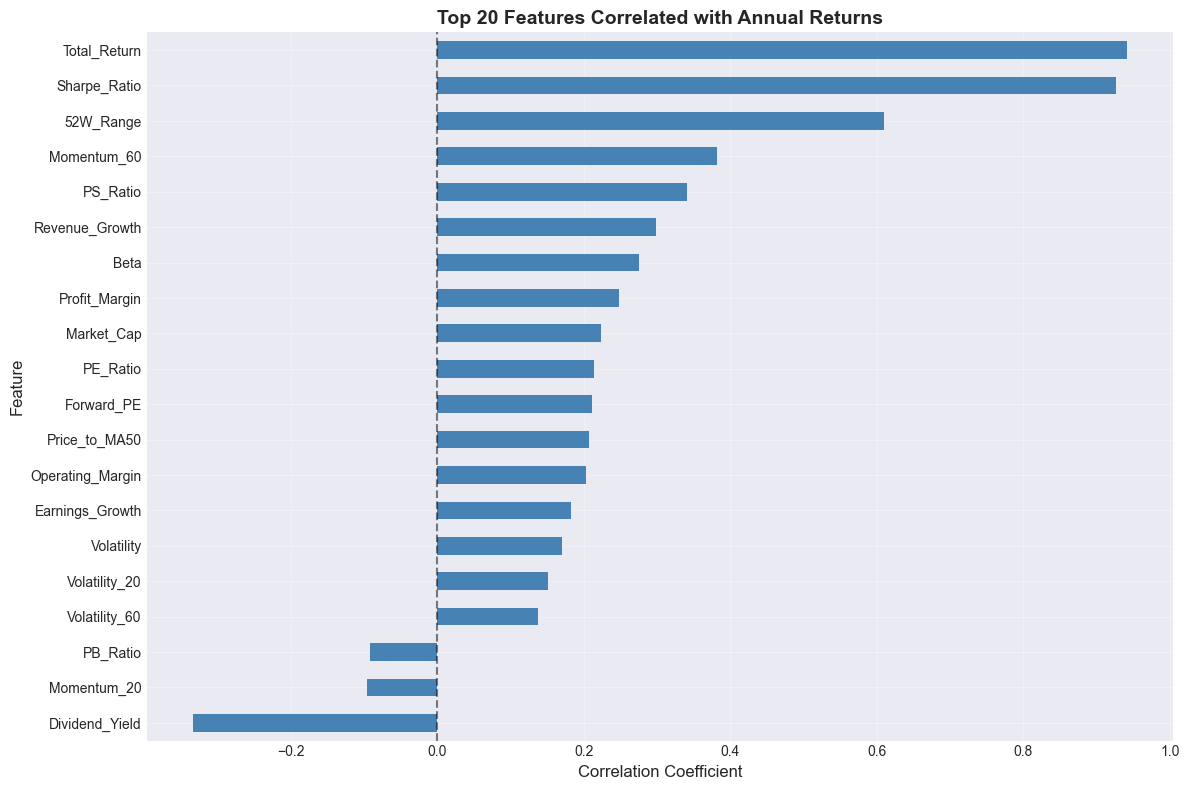

In [39]:
# Visualize correlation with returns
top_correlations = correlations_with_returns.drop('Annual_Return').abs().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
correlations_with_returns[top_correlations.index].sort_values().plot(kind='barh', color='steelblue')
plt.title('Top 20 Features Correlated with Annual Returns', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

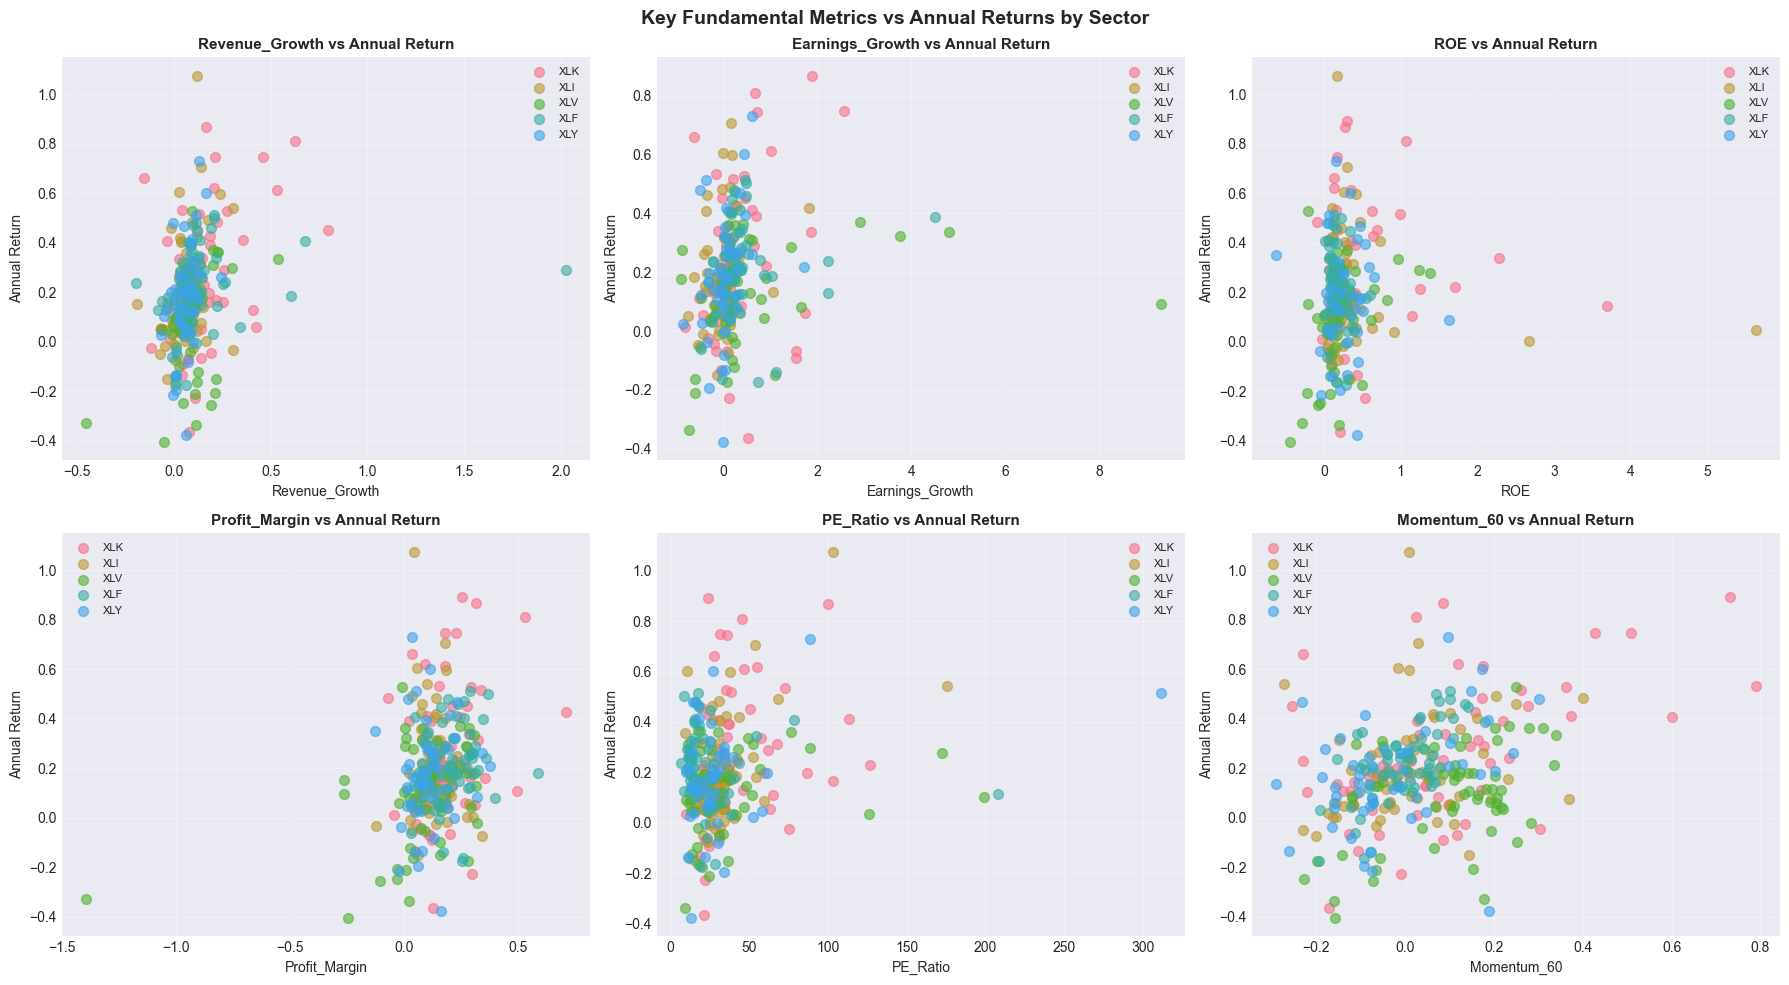

In [40]:
# Scatter plots of key fundamental metrics vs returns
key_fundamentals = ['Revenue_Growth', 'Earnings_Growth', 'ROE', 'Profit_Margin', 'PE_Ratio', 'Momentum_60']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_fundamentals):
    if feature in full_features_df.columns:
        ax = axes[idx]
        
        # Plot by sector
        for sector in full_features_df['Sector_Code'].unique():
            sector_data = full_features_df[full_features_df['Sector_Code'] == sector]
            ax.scatter(sector_data[feature], sector_data['Annual_Return'], 
                      label=sector, alpha=0.6, s=50)
        
        ax.set_xlabel(feature, fontsize=10)
        ax.set_ylabel('Annual Return', fontsize=10)
        ax.set_title(f'{feature} vs Annual Return', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

plt.suptitle('Key Fundamental Metrics vs Annual Returns by Sector', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Clustering Analysis

Group stocks with similar characteristics using K-Means and DBSCAN

In [41]:
# Prepare data for clustering - select key features and handle missing values
clustering_features = ['Market_Cap', 'PE_Ratio', 'PB_Ratio', 'ROE', 'Profit_Margin', 
                       'Revenue_Growth', 'Earnings_Growth', 'Beta', 
                       'Momentum_60', 'Volatility_60', 'RSI']

# Filter to stocks with sufficient data
clustering_df = full_features_df[['Symbol', 'Sector', 'Sector_Code'] + clustering_features].copy()
clustering_df = clustering_df.dropna(subset=clustering_features)

print(f"Stocks with complete data for clustering: {len(clustering_df)}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_df[clustering_features])

print(f"Scaled feature matrix shape: {X_scaled.shape}")

Stocks with complete data for clustering: 262
Scaled feature matrix shape: (262, 11)


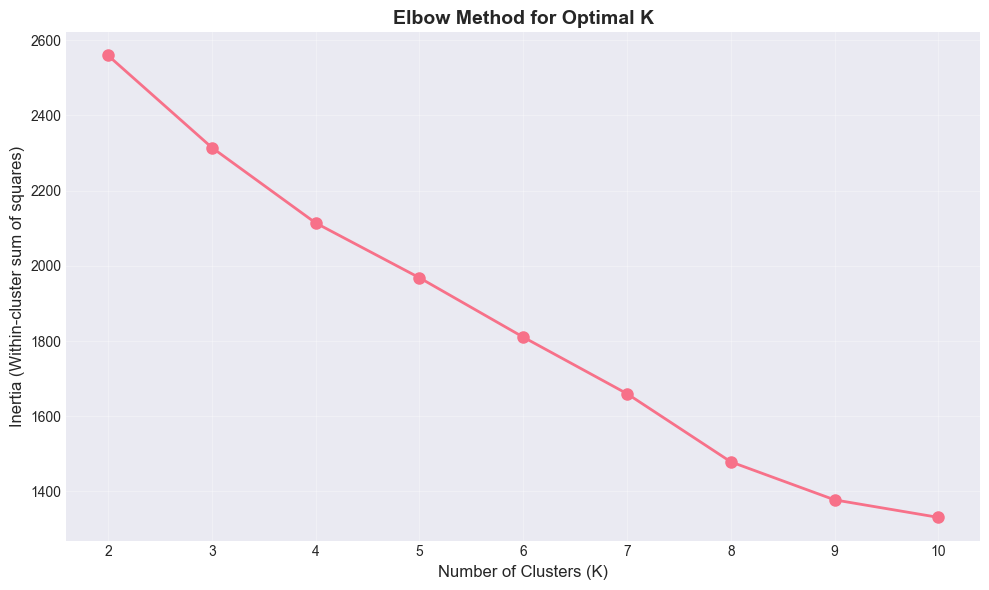

In [42]:
# Determine optimal number of clusters using elbow method
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [43]:
# Apply K-Means clustering
optimal_k = 5  # Based on elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clustering_df['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"K-Means clustering with K={optimal_k}")
print(f"\nCluster distribution:")
print(clustering_df['Cluster'].value_counts().sort_index())

K-Means clustering with K=5

Cluster distribution:
Cluster
0     4
1    59
2    99
3     9
4    91
Name: count, dtype: int64



Cluster Characteristics (Mean Values):
           Market_Cap  PE_Ratio  PB_Ratio    ROE  Profit_Margin  \
Cluster                                                           
0        3.213283e+10    27.020    47.758  3.574          0.217   
1        4.768841e+10    27.767     5.403  0.218          0.135   
2        8.560228e+10    30.740     4.540  0.272          0.150   
3        2.167455e+12    83.933    20.441  0.542          0.253   
4        9.332319e+10    31.693     7.321  0.232          0.189   

         Revenue_Growth  Earnings_Growth   Beta  Momentum_60  Volatility_60  \
Cluster                                                                       
0                 0.068            0.061  1.034       -0.079          0.268   
1                 0.009            0.049  1.344       -0.112          0.360   
2                 0.087            0.250  0.775       -0.017          0.228   
3                 0.295            1.284  1.418        0.181          0.420   
4               

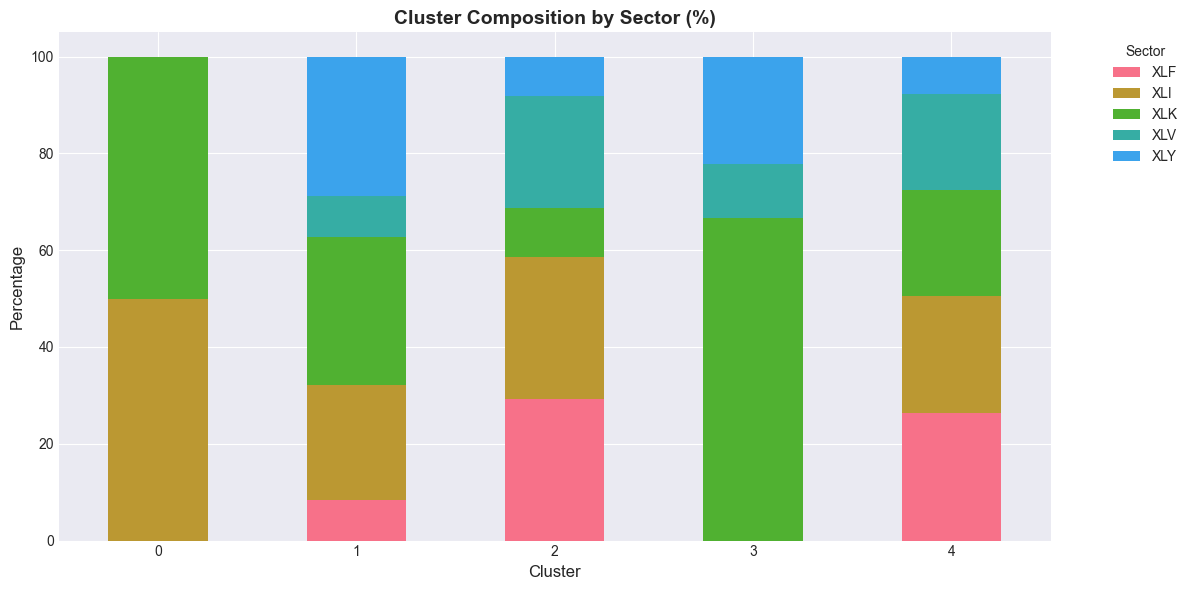

In [44]:
# Analyze cluster characteristics
cluster_summary = clustering_df.groupby('Cluster')[clustering_features].mean()
print("\nCluster Characteristics (Mean Values):")
print(cluster_summary.round(3))

# Visualize cluster composition by sector
cluster_sector = pd.crosstab(clustering_df['Cluster'], clustering_df['Sector_Code'], normalize='index') * 100

plt.figure(figsize=(12, 6))
cluster_sector.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Cluster Composition by Sector (%)', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 6. Dimensionality Reduction (PCA)

Reduce feature space and visualize stock relationships

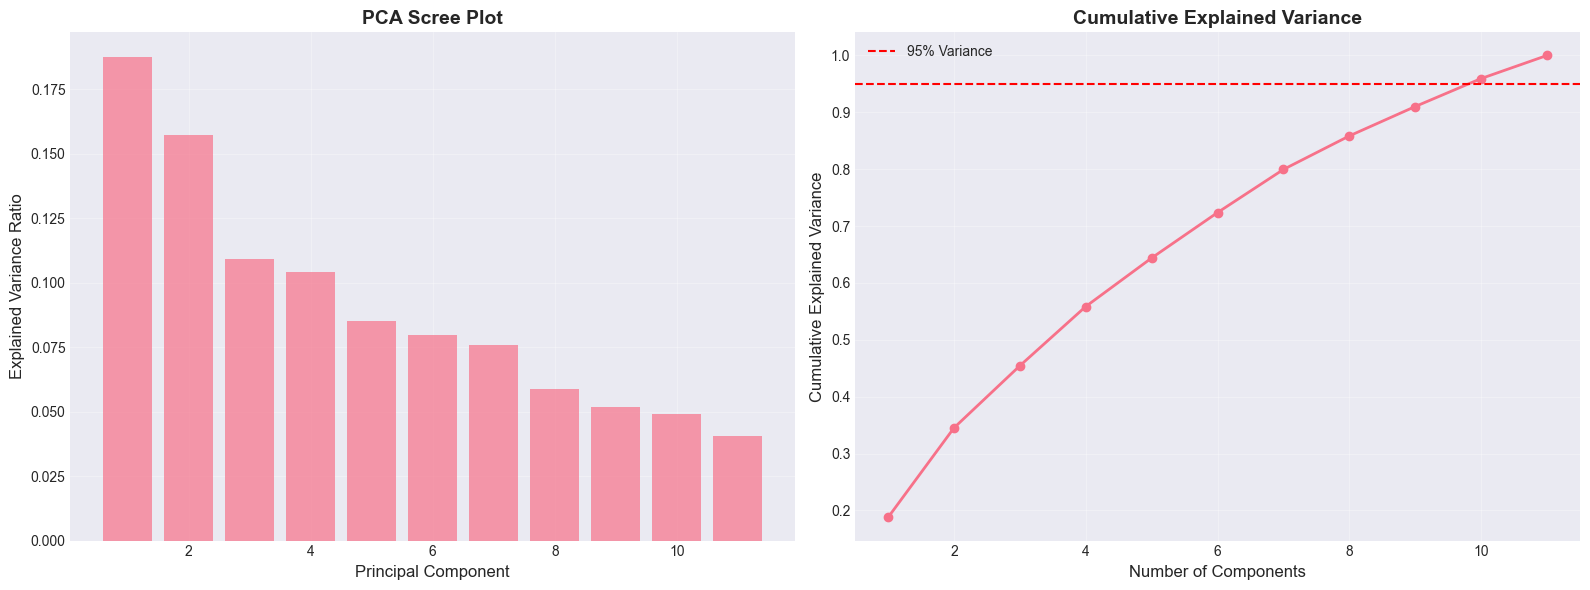


First 5 components explain 64.39% of variance
Components needed for 95% variance: 10


In [45]:
# Apply PCA
pca = PCA()
pca_features = pca.fit_transform(X_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Scree plot
ax1.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Explained Variance Ratio', fontsize=12)
ax1.set_title('PCA Scree Plot', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Cumulative variance
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linewidth=2)
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Explained Variance', fontsize=12)
ax2.set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFirst 5 components explain {cumulative_variance[4]:.2%} of variance")
print(f"Components needed for 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}")

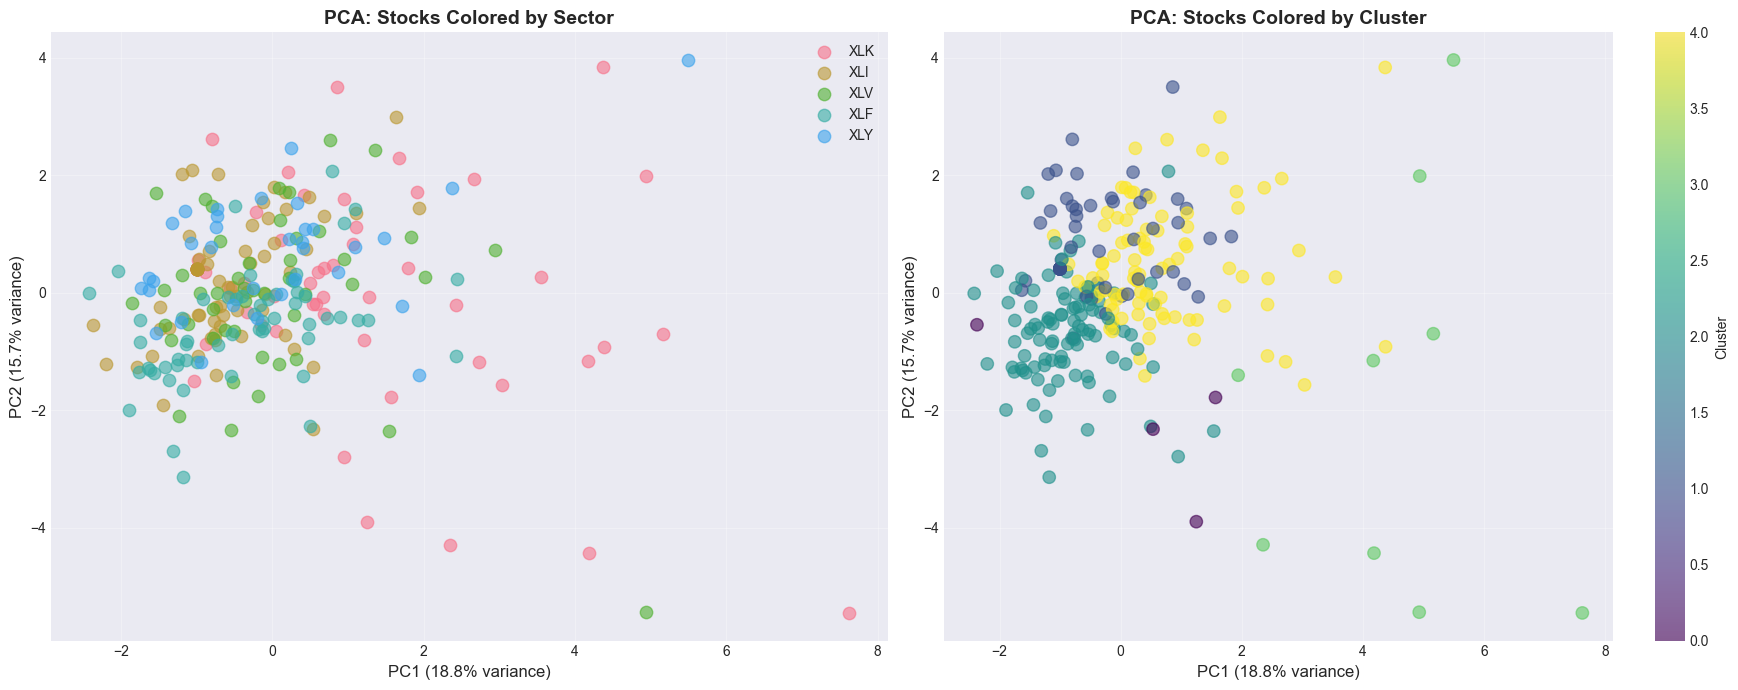

In [46]:
# Visualize stocks in 2D PCA space
clustering_df['PC1'] = pca_features[:, 0]
clustering_df['PC2'] = pca_features[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Color by sector
for sector in clustering_df['Sector_Code'].unique():
    sector_data = clustering_df[clustering_df['Sector_Code'] == sector]
    ax1.scatter(sector_data['PC1'], sector_data['PC2'], label=sector, alpha=0.6, s=80)

ax1.set_xlabel(f'PC1 ({explained_variance[0]:.1%} variance)', fontsize=12)
ax1.set_ylabel(f'PC2 ({explained_variance[1]:.1%} variance)', fontsize=12)
ax1.set_title('PCA: Stocks Colored by Sector', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Color by cluster
scatter = ax2.scatter(clustering_df['PC1'], clustering_df['PC2'], 
                     c=clustering_df['Cluster'], cmap='viridis', alpha=0.6, s=80)
ax2.set_xlabel(f'PC1 ({explained_variance[0]:.1%} variance)', fontsize=12)
ax2.set_ylabel(f'PC2 ({explained_variance[1]:.1%} variance)', fontsize=12)
ax2.set_title('PCA: Stocks Colored by Cluster', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax2, label='Cluster')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Feature Loadings on First 3 Principal Components:
                   PC1    PC2    PC3
Market_Cap       0.343 -0.303 -0.334
PE_Ratio         0.281  0.214 -0.286
PB_Ratio         0.211 -0.185 -0.140
ROE              0.053 -0.234 -0.426
Profit_Margin    0.228 -0.403  0.007
Revenue_Growth   0.415 -0.281  0.141
Earnings_Growth  0.254 -0.335  0.413
Beta             0.361  0.325 -0.341
Momentum_60      0.386  0.132  0.497
Volatility_60    0.386  0.363 -0.074
RSI              0.197  0.405  0.215


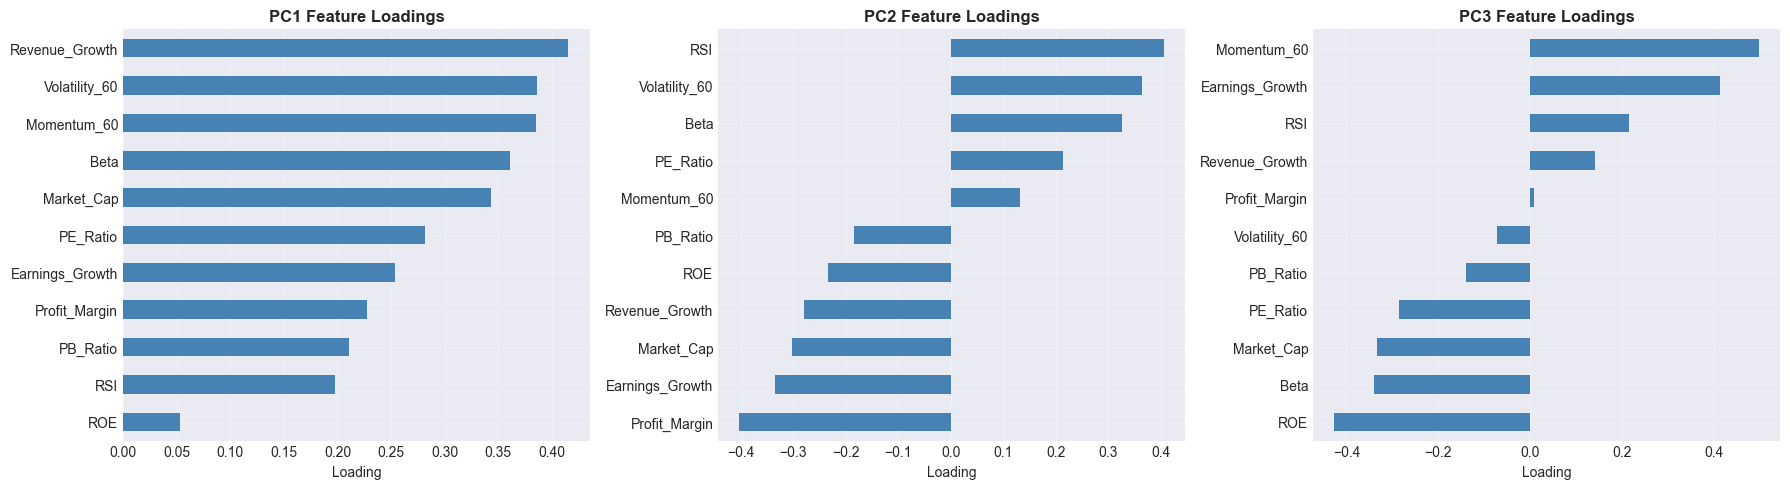

In [47]:
# Feature contributions to principal components
loadings = pd.DataFrame(
    pca.components_[:3, :].T,
    columns=['PC1', 'PC2', 'PC3'],
    index=clustering_features
)

print("Feature Loadings on First 3 Principal Components:")
print(loadings.round(3))

# Visualize loadings
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, pc in enumerate(['PC1', 'PC2', 'PC3']):
    loadings[pc].sort_values().plot(kind='barh', ax=axes[idx], color='steelblue')
    axes[idx].set_title(f'{pc} Feature Loadings', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Loading', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Predictive Modeling

Build models to predict stock returns based on fundamentals and technical features

In [48]:
# Prepare modeling dataset
model_features = ['Market_Cap', 'PE_Ratio', 'PB_Ratio', 'ROE', 'ROA', 'Profit_Margin',
                  'Operating_Margin', 'Revenue_Growth', 'Earnings_Growth', 'Beta',
                  'Debt_to_Equity', 'Dividend_Yield', 
                  'MA_20', 'MA_50', 'Price_to_MA20', 'Price_to_MA50',
                  'Momentum_20', 'Momentum_60', 'Volatility_20', 'Volatility_60', 'RSI']

target = 'Annual_Return'

# Filter to stocks with complete data
model_df = full_features_df[['Symbol'] + model_features + [target]].dropna()

print(f"Modeling dataset: {len(model_df)} stocks with complete data")
print(f"Features: {len(model_features)}")

X = model_df[model_features]
y = model_df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set: {len(X_train)} stocks")
print(f"Test set: {len(X_test)} stocks")

Modeling dataset: 189 stocks with complete data
Features: 21

Training set: 151 stocks
Test set: 38 stocks


In [49]:
# Scale features
scaler_model = StandardScaler()
X_train_scaled = scaler_model.fit_transform(X_train)
X_test_scaled = scaler_model.transform(X_test)

# Train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.001),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

results = {}

print("Training models...\n")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results[name] = {
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Test RMSE': test_rmse,
        'Test MAE': test_mae,
        'Predictions': y_test_pred
    }
    
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Test MAE: {test_mae:.4f}\n")

print("Model training complete!")

Training models...

Training Linear Regression...
  Train R²: 0.5435
  Test R²: 0.2945
  Test RMSE: 0.1478
  Test MAE: 0.1125

Training Ridge Regression...
  Train R²: 0.5291
  Test R²: 0.3906
  Test RMSE: 0.1374
  Test MAE: 0.1088

Training Lasso Regression...
  Train R²: 0.5216
  Test R²: 0.3828
  Test RMSE: 0.1383
  Test MAE: 0.1076

Training Random Forest...
  Train R²: 0.9204
  Test R²: 0.4442
  Test RMSE: 0.1312
  Test MAE: 0.0972

Training Gradient Boosting...
  Train R²: 1.0000
  Test R²: 0.4585
  Test RMSE: 0.1295
  Test MAE: 0.0927

Model training complete!


Model Performance Comparison:
                   Train R²   Test R² Test RMSE  Test MAE
Linear Regression  0.543483  0.294518  0.147845  0.112474
Ridge Regression   0.529056   0.39062  0.137407  0.108784
Lasso Regression   0.521574  0.382825  0.138283  0.107575
Random Forest      0.920391  0.444169  0.131231  0.097168
Gradient Boosting  0.999954  0.458501  0.129528  0.092676


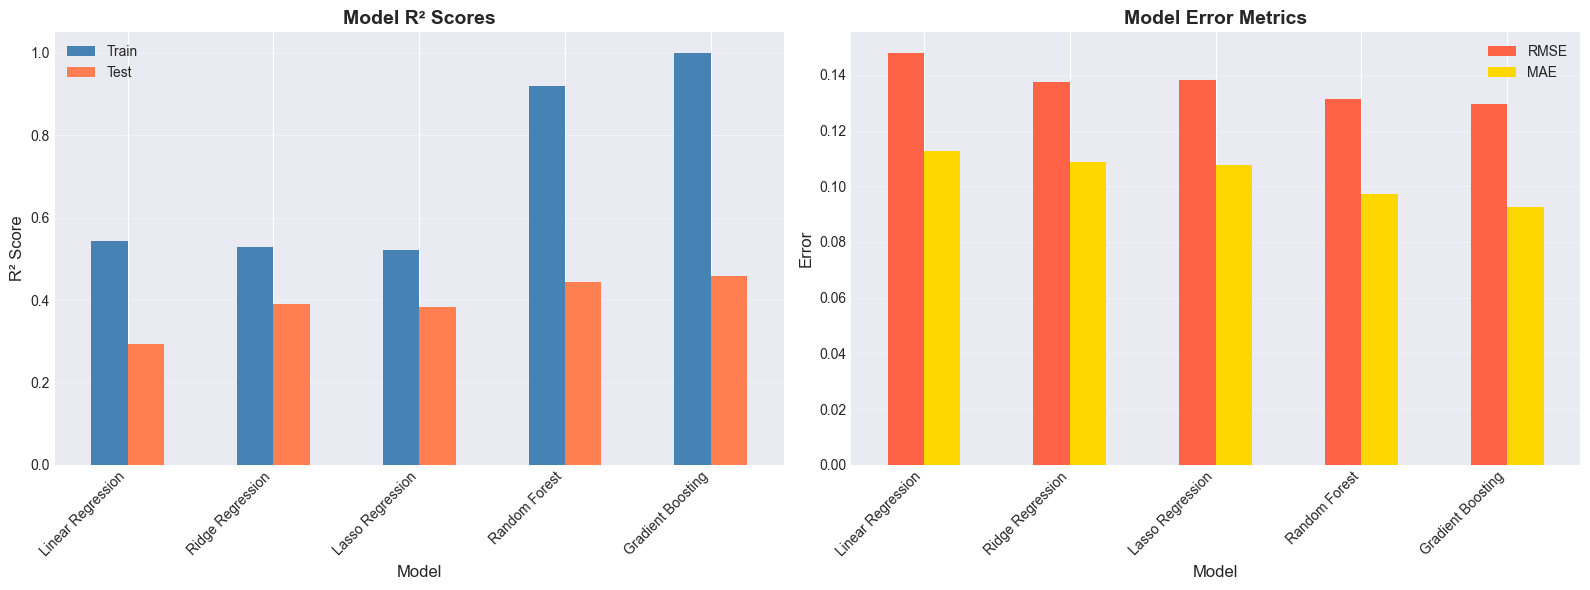

In [50]:
# Compare model performance
results_df = pd.DataFrame(results).T
results_df = results_df.drop('Predictions', axis=1)

print("Model Performance Comparison:")
print(results_df.round(4))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# R² scores
results_df[['Train R²', 'Test R²']].plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Model R² Scores', fontsize=14, fontweight='bold')
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].legend(['Train', 'Test'])
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Error metrics
results_df[['Test RMSE', 'Test MAE']].plot(kind='bar', ax=axes[1], color=['tomato', 'gold'])
axes[1].set_title('Model Error Metrics', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Error', fontsize=12)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].legend(['RMSE', 'MAE'])
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

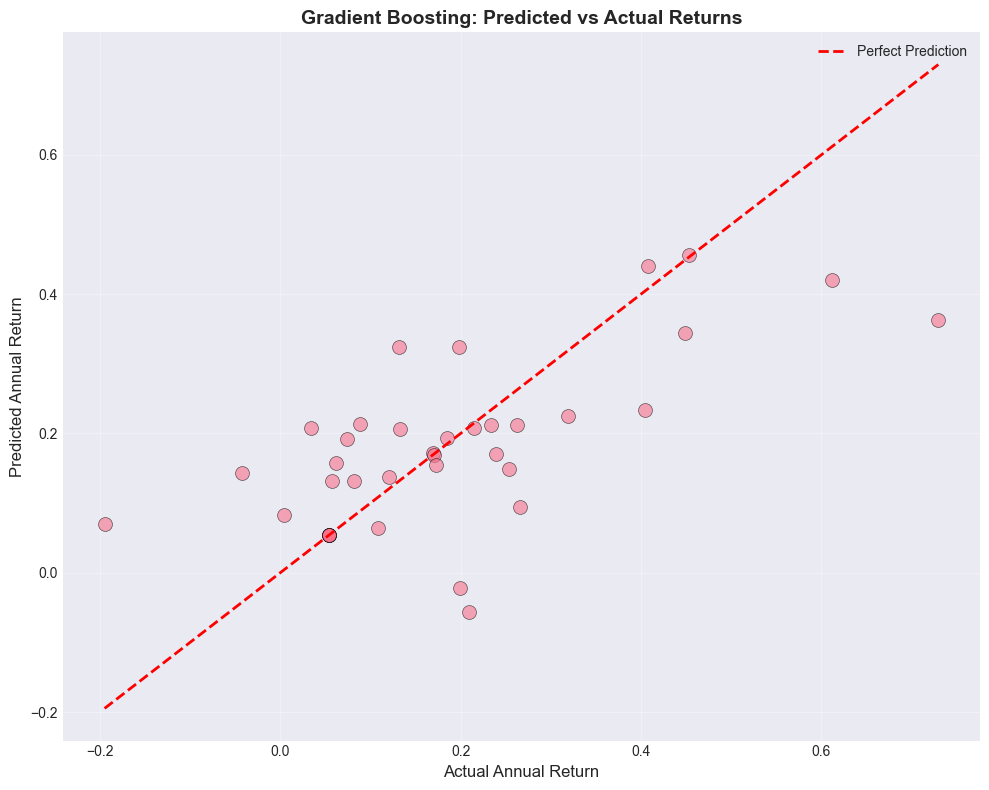

Best model: Gradient Boosting
Test R²: 0.4585


In [51]:
# Plot predictions vs actual for best model
best_model_name = results_df['Test R²'].idxmax()
best_predictions = results[best_model_name]['Predictions']

plt.figure(figsize=(10, 8))
plt.scatter(y_test, best_predictions, alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Annual Return', fontsize=12)
plt.ylabel('Predicted Annual Return', fontsize=12)
plt.title(f'{best_model_name}: Predicted vs Actual Returns', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Best model: {best_model_name}")
print(f"Test R²: {results[best_model_name]['Test R²']:.4f}")

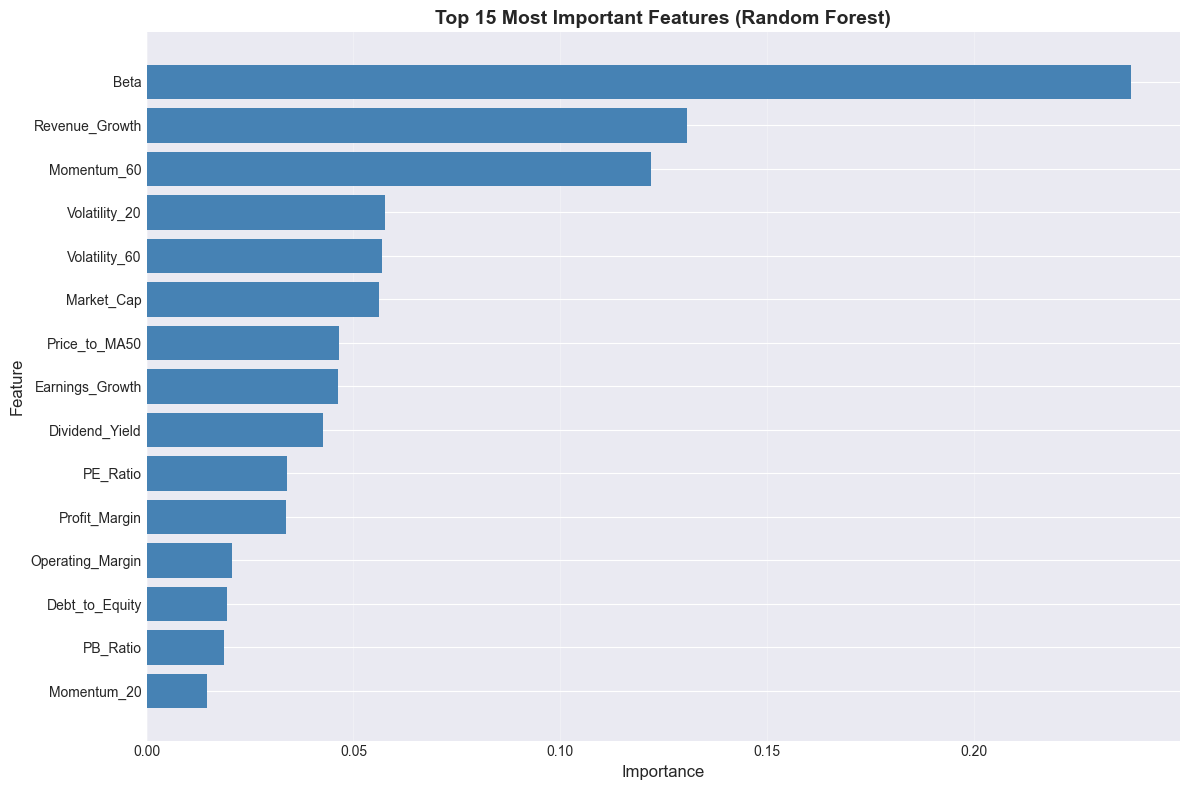


Top 10 Most Important Features:
            Feature  Importance
9              Beta    0.238032
7    Revenue_Growth    0.130600
17      Momentum_60    0.121929
18    Volatility_20    0.057741
19    Volatility_60    0.056943
0        Market_Cap    0.056129
15    Price_to_MA50    0.046559
8   Earnings_Growth    0.046378
11   Dividend_Yield    0.042574
1          PE_Ratio    0.033982


In [52]:
# Feature importance from Random Forest
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'Feature': model_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'].head(15), feature_importance['Importance'].head(15), color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

## 8. Sector Deep Dive Comparison

In [53]:
# Comprehensive sector comparison
sector_analysis = full_features_df.groupby('Sector_Code').agg({
    'Annual_Return': ['mean', 'std', 'min', 'max'],
    'Volatility': ['mean', 'std'],
    'Sharpe_Ratio': ['mean', 'std'],
    'PE_Ratio': ['mean', 'median'],
    'PB_Ratio': ['mean', 'median'],
    'ROE': ['mean', 'median'],
    'Profit_Margin': ['mean', 'median'],
    'Revenue_Growth': ['mean', 'median'],
    'Beta': ['mean', 'median'],
    'Symbol': 'count'
}).round(4)

sector_analysis.columns = ['_'.join(col).strip() for col in sector_analysis.columns.values]
sector_analysis = sector_analysis.rename(columns={'Symbol_count': 'Stock_Count'})

print("Comprehensive Sector Analysis:")
print(sector_analysis)

Comprehensive Sector Analysis:
             Annual_Return_mean  Annual_Return_std  Annual_Return_min  \
Sector_Code                                                             
XLF                      0.2182             0.1516            -0.1727   
XLI                      0.1878             0.2033            -0.1489   
XLK                      0.2337             0.2628            -0.3646   
XLV                      0.0941             0.1954            -0.4046   
XLY                      0.1688             0.2102            -0.3776   

             Annual_Return_max  Volatility_mean  Volatility_std  \
Sector_Code                                                       
XLF                     0.5134           0.2648          0.0584   
XLI                     1.0753           0.2837          0.0749   
XLK                     0.8915           0.3801          0.1339   
XLV                     0.5268           0.3301          0.1168   
XLY                     0.7295           0.3333        

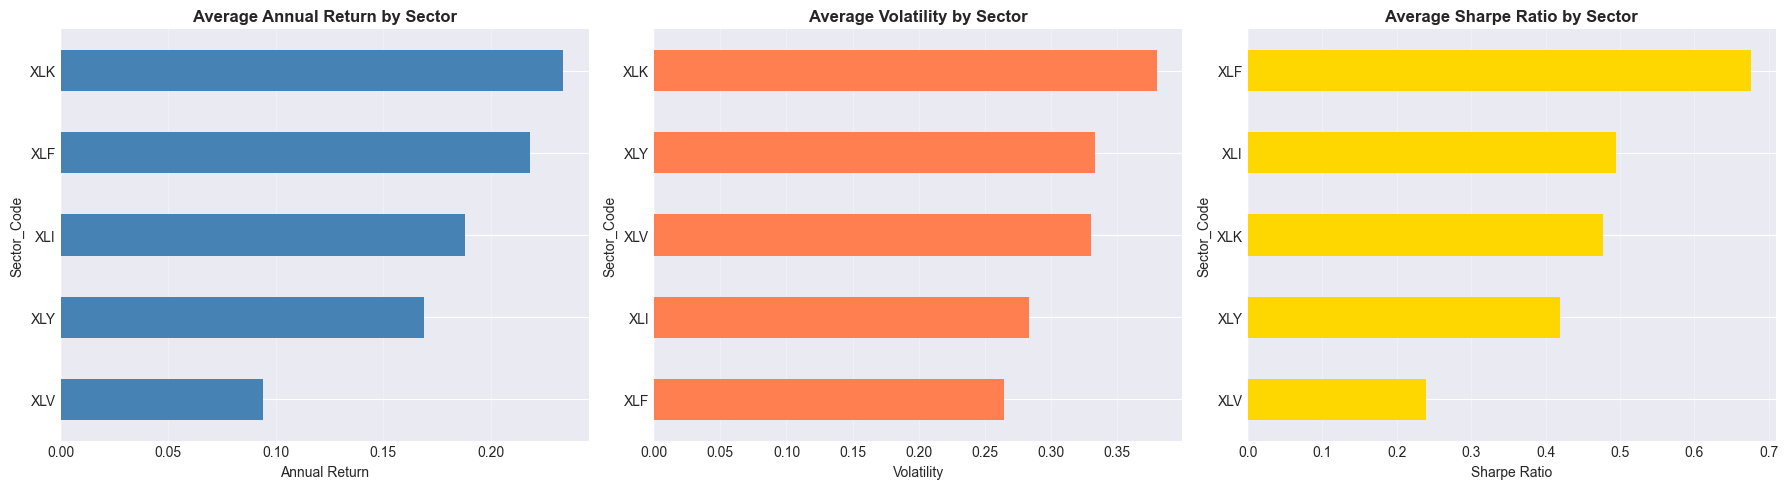

In [54]:
# Visualize sector performance metrics
sector_metrics = full_features_df.groupby('Sector_Code')[['Annual_Return', 'Volatility', 'Sharpe_Ratio']].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Annual Return
sector_metrics['Annual_Return'].sort_values().plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Average Annual Return by Sector', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Annual Return', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='x')

# Volatility
sector_metrics['Volatility'].sort_values().plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Average Volatility by Sector', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Volatility', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='x')

# Sharpe Ratio
sector_metrics['Sharpe_Ratio'].sort_values().plot(kind='barh', ax=axes[2], color='gold')
axes[2].set_title('Average Sharpe Ratio by Sector', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Sharpe Ratio', fontsize=10)
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

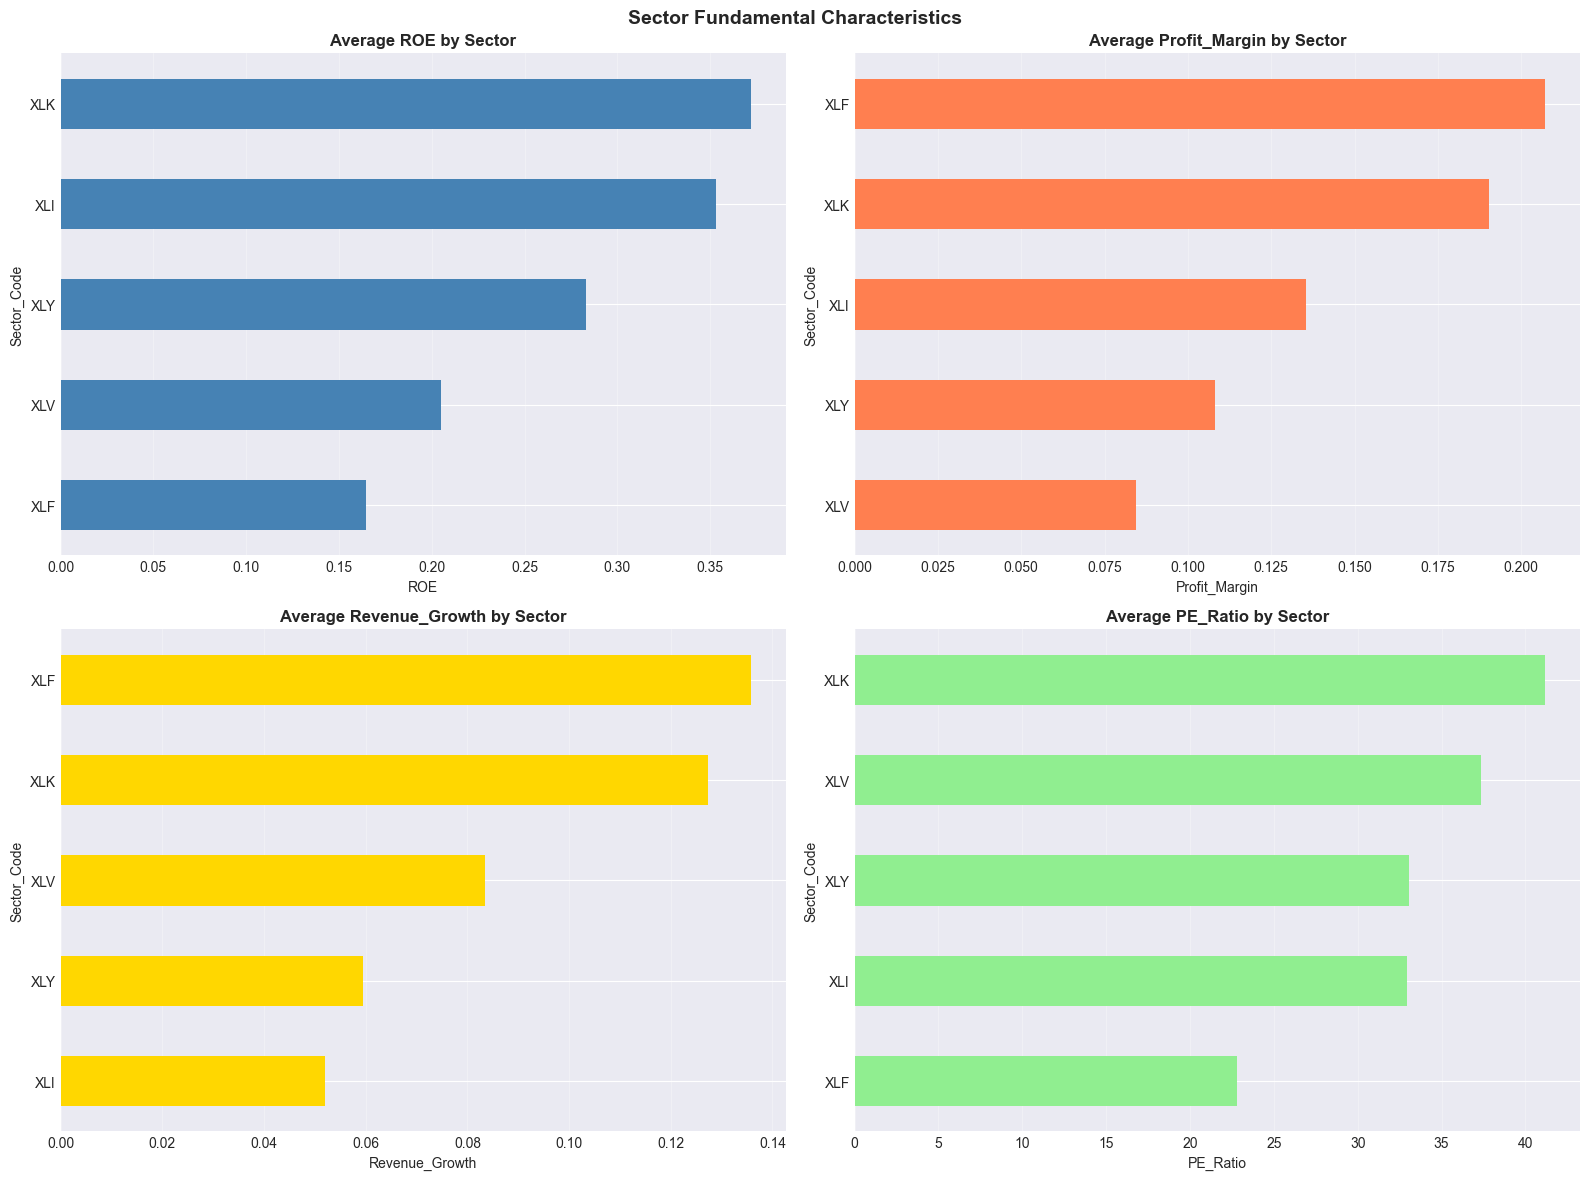

In [55]:
# Sector fundamental characteristics
sector_fundamentals = full_features_df.groupby('Sector_Code')[['ROE', 'Profit_Margin', 'Revenue_Growth', 'PE_Ratio']].mean()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metrics = ['ROE', 'Profit_Margin', 'Revenue_Growth', 'PE_Ratio']
colors = ['steelblue', 'coral', 'gold', 'lightgreen']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    sector_fundamentals[metric].sort_values().plot(kind='barh', ax=axes[idx], color=color)
    axes[idx].set_title(f'Average {metric} by Sector', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(metric, fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.suptitle('Sector Fundamental Characteristics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

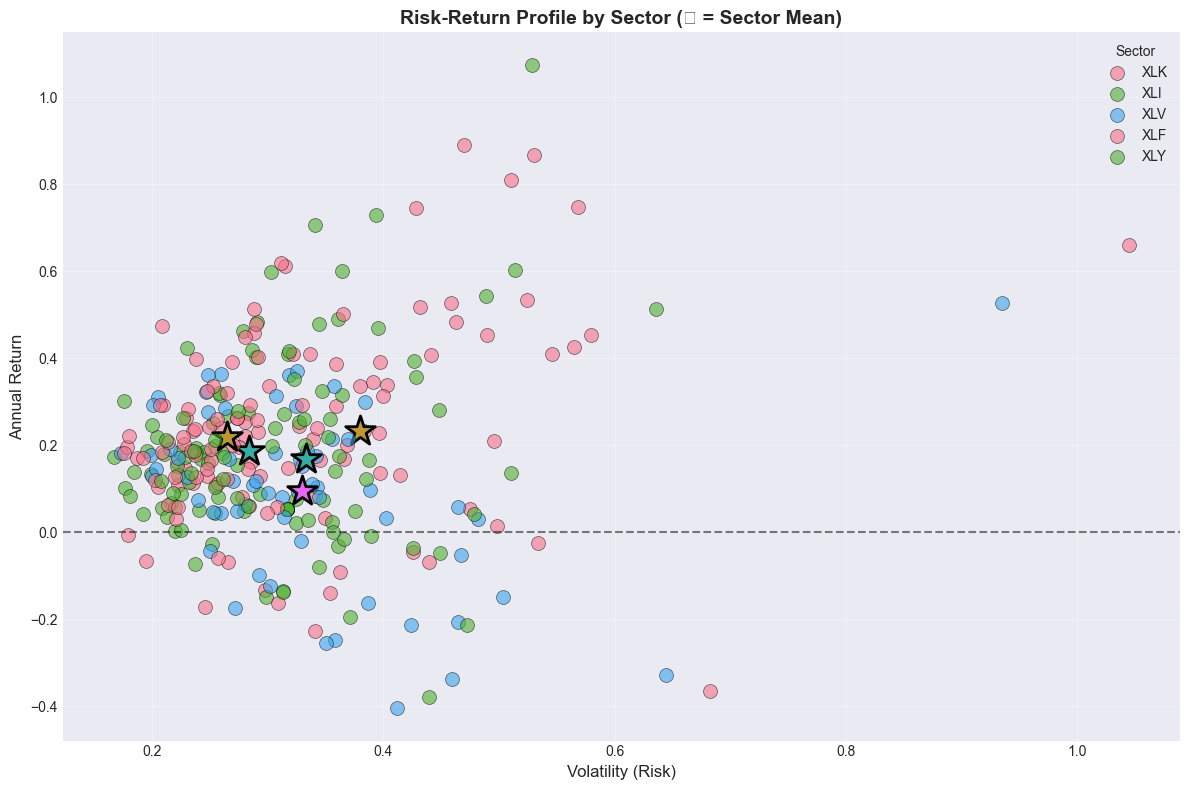

In [56]:
# Risk-return profile by sector
plt.figure(figsize=(12, 8))

for sector in full_features_df['Sector_Code'].unique():
    sector_data = full_features_df[full_features_df['Sector_Code'] == sector]
    plt.scatter(sector_data['Volatility'], sector_data['Annual_Return'], 
               label=sector, s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    # Add sector mean
    mean_vol = sector_data['Volatility'].mean()
    mean_ret = sector_data['Annual_Return'].mean()
    plt.scatter(mean_vol, mean_ret, s=500, marker='*', edgecolors='black', linewidth=2)

plt.xlabel('Volatility (Risk)', fontsize=12)
plt.ylabel('Annual Return', fontsize=12)
plt.title('Risk-Return Profile by Sector (★ = Sector Mean)', fontsize=14, fontweight='bold')
plt.legend(title='Sector', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 9. Key Insights and Summary

In [57]:
# Generate summary insights
print("="*80)
print("KEY INSIGHTS FROM ADVANCED ANALYSIS")
print("="*80)

print("\n1. CORRELATION ANALYSIS:")
print("   Top 3 features correlated with returns:")
for i, (feature, corr) in enumerate(correlations_with_returns.drop('Annual_Return').head(3).items(), 1):
    print(f"   {i}. {feature}: {corr:.3f}")

print("\n2. CLUSTERING:")
print(f"   Identified {optimal_k} distinct stock clusters")
print("   Clusters show mixed sector composition, indicating cross-sector similarities")

print("\n3. DIMENSIONALITY REDUCTION:")
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"   {n_components_95} principal components explain 95% of variance")
print(f"   First component explains {explained_variance[0]:.1%} of variation")

print("\n4. PREDICTIVE MODELING:")
print(f"   Best model: {best_model_name}")
print(f"   Test R²: {results[best_model_name]['Test R²']:.4f}")
print(f"   Test RMSE: {results[best_model_name]['Test RMSE']:.4f}")

print("\n5. SECTOR COMPARISON:")
best_sector = sector_metrics['Sharpe_Ratio'].idxmax()
worst_sector = sector_metrics['Sharpe_Ratio'].idxmin()
print(f"   Best risk-adjusted returns: {best_sector} (Sharpe: {sector_metrics.loc[best_sector, 'Sharpe_Ratio']:.3f})")
print(f"   Worst risk-adjusted returns: {worst_sector} (Sharpe: {sector_metrics.loc[worst_sector, 'Sharpe_Ratio']:.3f})")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

KEY INSIGHTS FROM ADVANCED ANALYSIS

1. CORRELATION ANALYSIS:
   Top 3 features correlated with returns:
   1. Total_Return: 0.941
   2. Sharpe_Ratio: 0.926
   3. 52W_Range: 0.609

2. CLUSTERING:
   Identified 5 distinct stock clusters
   Clusters show mixed sector composition, indicating cross-sector similarities

3. DIMENSIONALITY REDUCTION:
   10 principal components explain 95% of variance
   First component explains 18.8% of variation

4. PREDICTIVE MODELING:
   Best model: Gradient Boosting
   Test R²: 0.4585
   Test RMSE: 0.1295

5. SECTOR COMPARISON:
   Best risk-adjusted returns: XLF (Sharpe: 0.676)
   Worst risk-adjusted returns: XLV (Sharpe: 0.239)

ANALYSIS COMPLETE


## 10. Save Results

In [58]:
# Save all analysis results
full_features_df.to_csv('full_features_dataset.csv', index=False)
print("Full features dataset saved to 'full_features_dataset.csv'")

clustering_df.to_csv('clustering_results.csv', index=False)
print("Clustering results saved to 'clustering_results.csv'")

sector_analysis.to_csv('sector_detailed_analysis.csv')
print("Sector analysis saved to 'sector_detailed_analysis.csv'")

results_df.to_csv('model_performance_comparison.csv')
print("Model performance saved to 'model_performance_comparison.csv'")

print("\nAll results saved successfully!")

Full features dataset saved to 'full_features_dataset.csv'
Clustering results saved to 'clustering_results.csv'
Sector analysis saved to 'sector_detailed_analysis.csv'
Model performance saved to 'model_performance_comparison.csv'

All results saved successfully!
